In [1]:
#import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix

import h5py
import os

Using TensorFlow backend.


In [2]:
#Defining path for data loading
PATH = '/home/anish/anaconda_py3_copelia'
#PATH = '/home/anish/anaconda_py3_copelia'
data_path = PATH + '/Dataset_Red'             #Name of the folder that contains the data
data_dir_list = os.listdir(data_path)

print(data_path)
print(data_dir_list)

/home/anish/anaconda_py3_copelia/Dataset_Red
['test_set.h5', 'train_set.h5', 'val_set.h5']


In [3]:
#function to load dataset
def load_dataset():
    test_dataset = h5py.File(PATH + '/Dataset_Red/test_set.h5', "r")
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])    #test set features(images)
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])    #test set labels

    classes = np.array(test_dataset["list_classes"][:])          #list of classes
    
    #reshape labels into row vectors(sinle dimension vector)
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return test_set_x_orig, test_set_y_orig, classes

In [4]:
#function for one hot encoding
def convert_to_one_hot(Y, C):                                #C = no of labels
    Y = np.eye(C)[Y.reshape(-1)].T                           #reshape(-1) will convert it into a single dimension vector
    return Y

In [5]:
X_test_orig, Y_test_orig, classes = load_dataset()

#normalise image data
X_test = X_test_orig/255.
#one hot encode the labels
Y_test = convert_to_one_hot(Y_test_orig, 3).T

print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_test shape: (1561, 128, 128, 3)
Y_test shape: (1561, 3)


In [6]:
#Loading model with weights
# load model
model = load_model(PATH + '/Model/Quad_Net_Wt.h5')
# summarize model
model.summary()

Model: "QuadNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        11648     
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        51264     
_________________________________________________________________
relu2 (Activation)           (None, 16, 16, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0   

In [7]:
preds = model.evaluate(X_test, Y_test)

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1561/1561 [==============================] - 2s 1ms/step
Loss = 0.006175132067712987
Test Accuracy = 0.9980781674385071


In [8]:
predictions = model.predict(X_test)

In [9]:
predictions #this has probability for each class argmax need to be taken for confusion matrix

array([[1.0000000e+00, 7.4949487e-14, 3.6519837e-12],
       [1.0340642e-15, 1.0000000e+00, 1.6824531e-10],
       [2.8810039e-04, 4.3711432e-05, 9.9966824e-01],
       ...,
       [9.9999881e-01, 4.8632182e-07, 7.7277070e-07],
       [1.0866654e-03, 4.6473533e-02, 9.5243984e-01],
       [1.0000000e+00, 3.1261108e-11, 4.2876230e-11]], dtype=float32)

In [10]:
Y_test[0] #here also it is one hot encoding so we need arg max 

array([1., 0., 0.])

In [12]:
#classification report
target_names = ['FL', 'FR', 'FS']
print(classification_report(Y_test.argmax(axis=1), predictions.argmax(axis=1),
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

          FL     1.0000    1.0000    1.0000       506
          FR     0.9964    0.9982    0.9973       552
          FS     0.9980    0.9960    0.9970       503

    accuracy                         0.9981      1561
   macro avg     0.9981    0.9981    0.9981      1561
weighted avg     0.9981    0.9981    0.9981      1561



In [13]:
#confusion matrix
confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[506,   0,   0],
       [  0, 551,   1],
       [  0,   2, 501]])

In [14]:
#confusion matrix normalised
confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1), normalize='true')

array([[1.        , 0.        , 0.        ],
       [0.        , 0.99818841, 0.00181159],
       [0.        , 0.00397614, 0.99602386]])

In [16]:
conf_mat =confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1), normalize='true')

In [17]:
#convert confusion matrix to a pandas dataframe
df1 = pd.DataFrame(conf_mat,
                   columns=['FL', 'FR', 'FS'],
                   index=['FL', 'FR', 'FS'])
df1.head()

,FL,FR,FS
FL,1.0,0.000000,0.000000
FR,0.0,0.998188,0.001812
FS,0.0,0.003976,0.996024


In [18]:
df1['FR'] = df1['FR'].round(decimals=4)

In [19]:
df1['FS'] = df1['FS'].round(decimals=4)

In [21]:
df1.head()

,FL,FR,FS
FL,1.0,0.0000,0.0000
FR,0.0,0.9982,0.0018
FS,0.0,0.0040,0.9960


Text(33.0, 0.5, 'True Label')

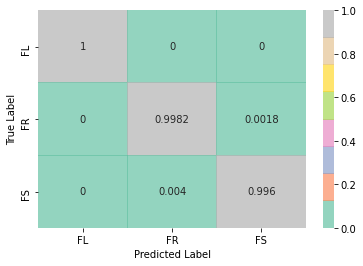

In [22]:
#plot the confusion matrix
fig = plt.figure()
sns.heatmap(df1, annot=True, fmt='g', cmap='Set2', alpha = 0.7)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [23]:
print (fig.canvas.get_supported_filetypes())

{'ps': 'Postscript', 'eps': 'Encapsulated Postscript', 'pdf': 'Portable Document Format', 'pgf': 'PGF code for LaTeX', 'png': 'Portable Network Graphics', 'raw': 'Raw RGBA bitmap', 'rgba': 'Raw RGBA bitmap', 'svg': 'Scalable Vector Graphics', 'svgz': 'Scalable Vector Graphics', 'jpg': 'Joint Photographic Experts Group', 'jpeg': 'Joint Photographic Experts Group', 'tif': 'Tagged Image File Format', 'tiff': 'Tagged Image File Format'}


In [24]:
#save confusion matrix in 'svg' file format
fig.savefig('cmatrix.svg')